Processing ResNet50...
Processing MobileNetV2...
Processing EfficientNet_B0...
Processing ViT_B_16...


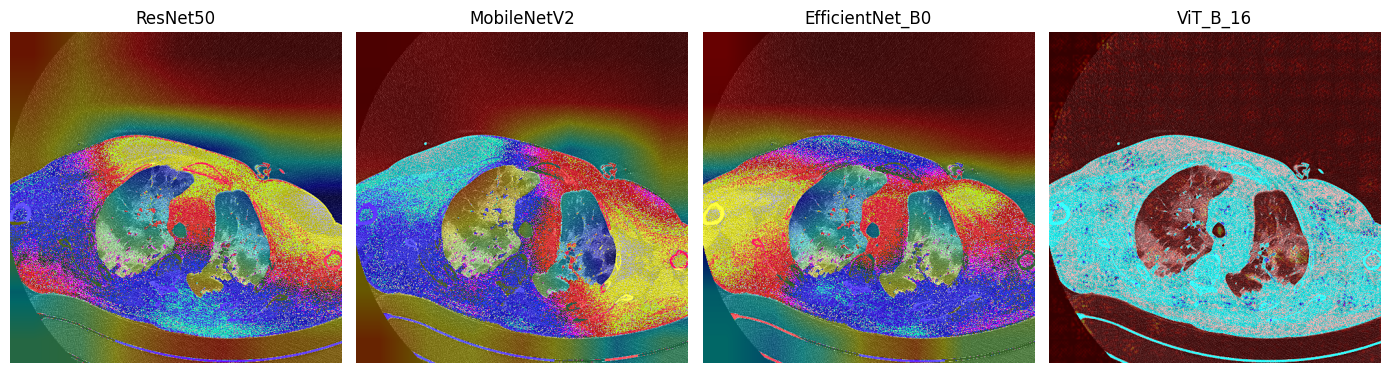

In [21]:
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import timm  # For ViT

# 图像路径
img_path = '/kaggle/input/large-covid19-ct-slice-dataset/curated_data/curated_data/2COVID/13_Bjorke_13.png'

# 通用图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

# ---- Grad-CAM for CNN ----
def grad_cam_cnn(model, target_layer):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    model.eval()
    output = model(input_tensor)
    class_idx = output.argmax()
    model.zero_grad()
    output[0, class_idx].backward()

    act = activations[0].squeeze(0).detach()
    grad = gradients[0].squeeze(0).detach()
    weights = torch.mean(grad, dim=(1, 2))
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam.numpy(), 0)
    cam = cv2.resize(cam, (img.width, img.height))
    cam -= cam.min()
    cam /= cam.max()

    handle_f.remove()
    handle_b.remove()
    return cam

# ---- Grad-CAM for ViT ----
def grad_cam_vit(model):
    model.eval()
    input_tensor.requires_grad_()

    output = model(input_tensor)
    class_idx = output.argmax()
    output[0, class_idx].backward()

    grad = input_tensor.grad
    cam = grad[0].mean(0).numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img.width, img.height))
    cam -= cam.min()
    cam /= cam.max()
    return cam

models_info = [
    ("ResNet50", models.resnet50(pretrained=True), lambda m: m.layer4[-1]),
    ("MobileNetV2", models.mobilenet_v2(pretrained=True), lambda m: m.features[-1]),
    ("EfficientNet_B0", models.efficientnet_b0(pretrained=True), lambda m: m.features[-1]),
    ("ViT_B_16", timm.create_model('vit_base_patch16_224', pretrained=True), None)
]

cams = []
titles = []

for name, model, get_layer in models_info:
    print(f"Processing {name}...")
    if "ViT" in name:
        cam = grad_cam_vit(model)
    else:
        target_layer = get_layer(model)
        cam = grad_cam_cnn(model, target_layer)
    cams.append(cam)
    titles.append(name)

img_np = np.array(img)
plt.figure(figsize=(14, 6))
for i in range(len(cams)):
    heatmap = cv2.applyColorMap(np.uint8(255 * cams[i]), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img_np
    plt.subplot(1, 4, i + 1)
    plt.title(titles[i])
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.axis('off')
plt.tight_layout()
plt.show()
